In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

def plot_spheric_3D(ax:Axes3D, theta:np.ndarray, phi:np.ndarray, color_value:np.ndarray, cmap='viridis'):
    """
    Plot a 3D spherical surface.
    
    Parameters
    ----------
    ax : plt.Axes
        The axes to plot on.
    theta, phi : np.ndarray
        2D meshgrid of the angles theta and phi.
    color_value : np.ndarray
        values of the function to plot on the surface.
    cmap:'viridis','plasma','inferno','magma','cividis'
    """
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    cmap = plt.cm.get_cmap(cmap)
    ax.plot_surface(x, y, z, facecolors=cmap(color_value), shade=True, rstride=1, cstride=1, linewidth=0)

    # Set the axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')


# 探测器响应

## (a) The analytical $F_+$ and $F_{\times} $
$$ F_+ = \frac{1}{2}(1+\cos^2\theta)\cos(2\phi) $$
$$ F_{\times} = \cos\theta\sin(2\phi) $$

/tmp/ipykernel_2572799/3478882205.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)


Text(0.5, 0.92, '$F_{\\times}$')

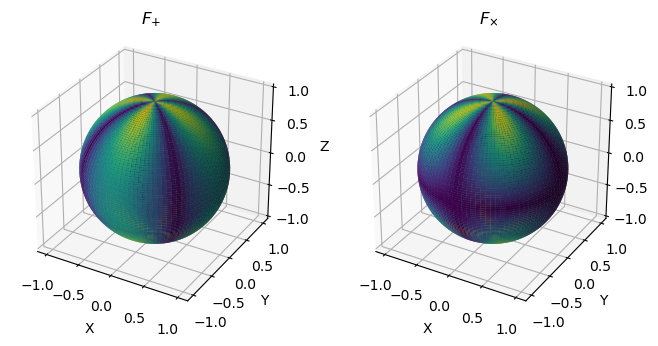

In [2]:
theta_range = np.linspace(0, np.pi, 100)
phi_range = np.linspace(0, 2*np.pi, 100)

theta, phi = np.meshgrid(theta_range, phi_range)
Fplus = 0.5*(1+np.cos(theta)**2)*np.cos(2*phi)
Fcross = np.cos(theta)*np.sin(2*phi)

fig = plt.figure(figsize=(8, 18))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_spheric_3D(ax1, theta, phi, np.abs(Fplus))
plot_spheric_3D(ax2, theta, phi, np.abs(Fcross))

ax1.set_title(r'$F_{+}$')
ax2.set_title(r'$F_{\times}$')


## (b) tensor contractions

$$ F_{+,\times} (\hat{n}) = \vec{D} \vec{e}_{+,\times} $$

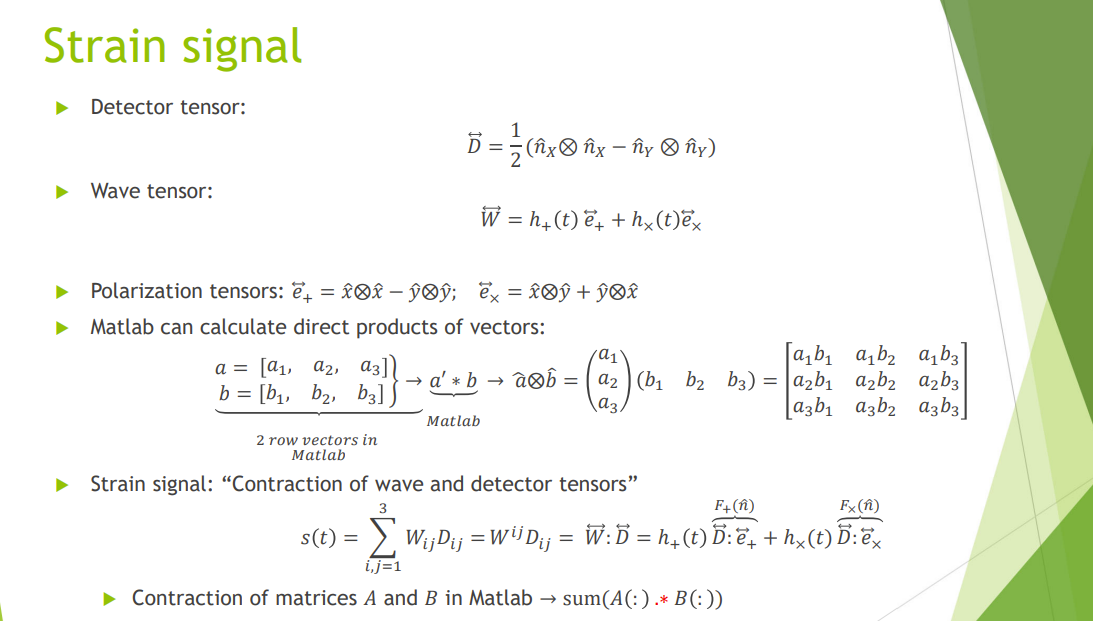


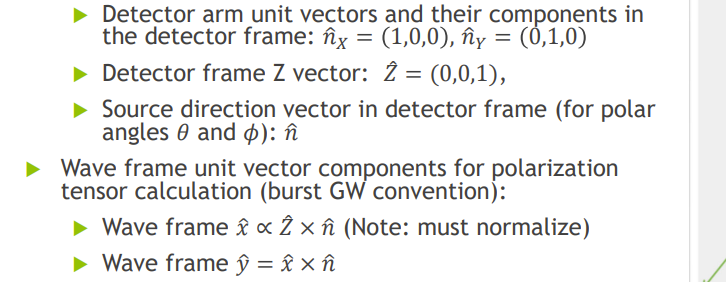

In [3]:
import numpy as np

def analy_response(theta, phi):
    Fplus = 0.5*(1+np.cos(theta)**2)*np.cos(2*phi)
    Fcross = np.cos(theta)*np.sin(2*phi)
    return Fplus, Fcross

@np.vectorize#使用 np.vectorize 将标量函数应用于数组元素
def tensor_response(theta, phi):
    # 定义探测器单位向量
    nx, ny, nz = np.eye(3)
    # 计算探测器张量
    detector_tensor = 0.5 * np.outer(nx, nx) - 0.5 * np.outer(ny, ny)

    # 计算波矢量
    wave_n = np.array([np.sin(theta) * np.cos(phi),
                       np.sin(theta) * np.sin(phi), np.cos(theta)])
    
    # 计算波矢量与单位向量 nz 的叉积
    wave_x = np.cross(nz, wave_n)
    
    # 归一化 wave_x
    wave_x /= np.linalg.norm(wave_x)
    
    # 计算 wave_y
    wave_y = np.cross(wave_n, wave_x)

    # 计算两个极化张量
    polar_tensor_plus = np.outer(wave_x, wave_x) - np.outer(wave_y, wave_y)
    polar_tensor_cross = np.outer(wave_x, wave_y) + np.outer(wave_y, wave_x)
    
    # 计算极化的天线响应
    Fplus = np.sum(polar_tensor_plus * detector_tensor)
    Fcross = np.sum(polar_tensor_cross * detector_tensor)
    
    return Fplus, Fcross

# 示例调用
theta = np.pi / 4
phi = np.pi / 3
Fplus, Fcross =tensor_response(theta, phi)
print(f"tensor_response:Fplus: {Fplus}, Fcross: {Fcross}")

Fplus1, Fcross1 = analy_response(theta, phi)
print(f"analy_response:Fplus: {Fplus1}, Fcross: {Fcross1}")

tensor_response:Fplus: 0.3749999999999999, Fcross: 0.6123724356957947
analy_response:Fplus: -0.37499999999999983, Fcross: 0.6123724356957946


/tmp/ipykernel_2572799/2929247111.py:23: RuntimeWarning: invalid value encountered in divide
  wave_x /= np.linalg.norm(wave_x)
/tmp/ipykernel_2572799/3478882205.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)


Text(0.5, 0.92, '$F_{\\times}$')

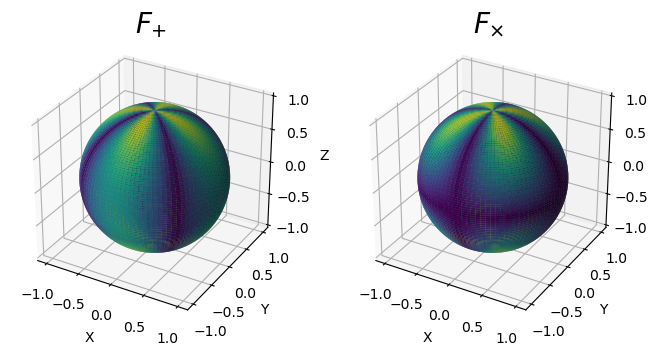

In [4]:
theta_range = np.linspace(0, np.pi, 100)
phi_range = np.linspace(0, 2*np.pi, 100)
theta, phi = np.meshgrid(theta_range, phi_range)

Fplus_tensor, Fcross_tensor = tensor_response(theta, phi)

fig = plt.figure(figsize=(8, 18))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_spheric_3D(ax1, theta, phi, np.abs(Fplus_tensor))
plot_spheric_3D(ax2, theta, phi, np.abs(Fcross_tensor))
ax1.set_title(r'$F_{+}$',fontsize=20)
ax2.set_title(r'$F_{\times}$',fontsize=20)

## (c) wave frame conventions

$$x_1=x \cos(\psi)-y \sin(\psi)$$
$$y_1=x \sin(\psi)+y \cos(\psi)$$

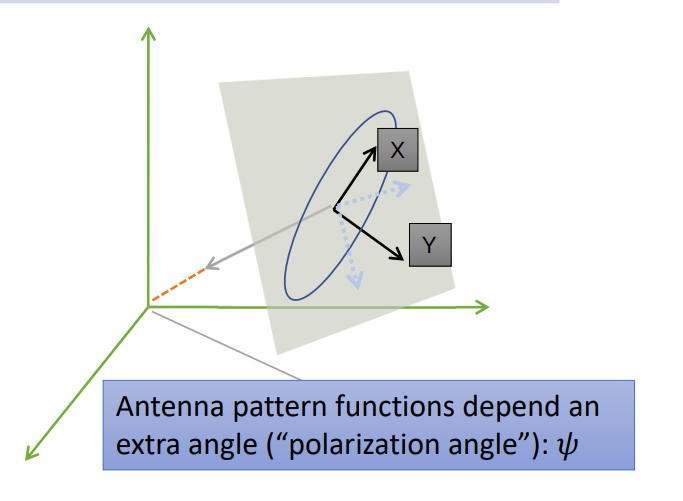

In [5]:
@np.vectorize#使用 np.vectorize 将标量函数应用于数组元素
def tensor_response_conven(theta, phi,psi=np.pi/4):
    # 定义探测器单位向量
    nx, ny, nz = np.eye(3)
    # 计算探测器张量
    detector_tensor = 0.5 * np.outer(nx, nx) - 0.5 * np.outer(ny, ny)

    # 计算波矢量
    wave_n = np.array([np.sin(theta) * np.cos(phi),
                       np.sin(theta) * np.sin(phi), np.cos(theta)])
    
    # 计算波矢量与单位向量 nz 的叉积
    wave_x = np.cross(nz, wave_n)
    # 归一化 wave_x
    wave_x /= np.linalg.norm(wave_x)
    # 计算 wave_y
    wave_y = np.cross(wave_n, wave_x)

    # xy逆时针旋转psi角
    wave_x1= wave_x*np.cos(psi)-wave_y*np.sin(psi)
    wave_y1 =  wave_x*np.sin(psi)+wave_y*np.cos(psi)
    # 计算两个极化张量
    polar_tensor_plus = np.outer(wave_x, wave_x) - np.outer(wave_y, wave_y)
    polar_tensor_cross = np.outer(wave_x, wave_y) + np.outer(wave_y, wave_x)
    
    # 计算极化态的天线响应
    Fplus = np.sum(polar_tensor_plus * detector_tensor)
    Fcross = np.sum(polar_tensor_cross * detector_tensor)
    
    return Fplus, Fcross


# 示例调用
theta = np.pi / 4
phi = np.pi / 3
Fplus, Fcross =tensor_response(theta, phi)
print(f"tensor_response:Fplus: {Fplus}, Fcross: {Fcross}")

Fplus1, Fcross1 = analy_response(theta, phi)
print(f"analy_response:Fplus: {Fplus1}, Fcross: {Fcross1}")

Fplus2, Fcross2 =tensor_response_conven(theta, phi,np.pi/6)
print(f"analy_response:Fplus: {Fplus2}, Fcross: {Fcross2}")

tensor_response:Fplus: 0.3749999999999999, Fcross: 0.6123724356957947
analy_response:Fplus: -0.37499999999999983, Fcross: 0.6123724356957946
analy_response:Fplus: 0.3749999999999999, Fcross: 0.6123724356957947


/tmp/ipykernel_2572799/841655103.py:15: RuntimeWarning: invalid value encountered in divide
  wave_x /= np.linalg.norm(wave_x)
/tmp/ipykernel_2572799/3478882205.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)


Text(0.5, 0.92, '$F_{\\times}$')

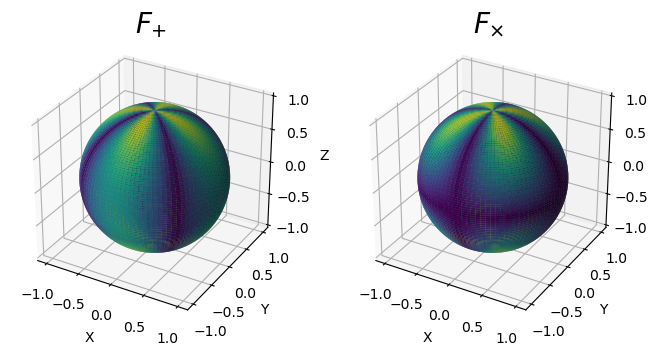

In [6]:
theta_range = np.linspace(0, np.pi, 100)
phi_range = np.linspace(0, 2*np.pi, 100)
theta, phi = np.meshgrid(theta_range, phi_range)

# Fplus_analy, Fcross_analy = analy_response(theta, phi)
# Fplus_tensor, Fcross_tensor = tensor_response(theta, phi)
Fplus_tensor_conven, Fcross_tensor_conven = tensor_response_conven(theta, phi)

fig = plt.figure(figsize=(8, 18))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_spheric_3D(ax1, theta, phi, np.abs(Fplus_tensor_conven))
plot_spheric_3D(ax2, theta, phi, np.abs(Fcross_tensor_conven))
ax1.set_title(r'$F_{+}$',fontsize=20)
ax2.set_title(r'$F_{\times}$',fontsize=20)



# non-evolving binary
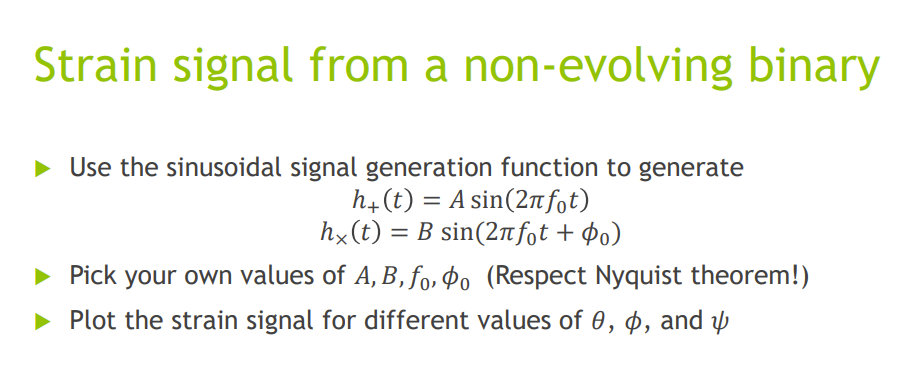

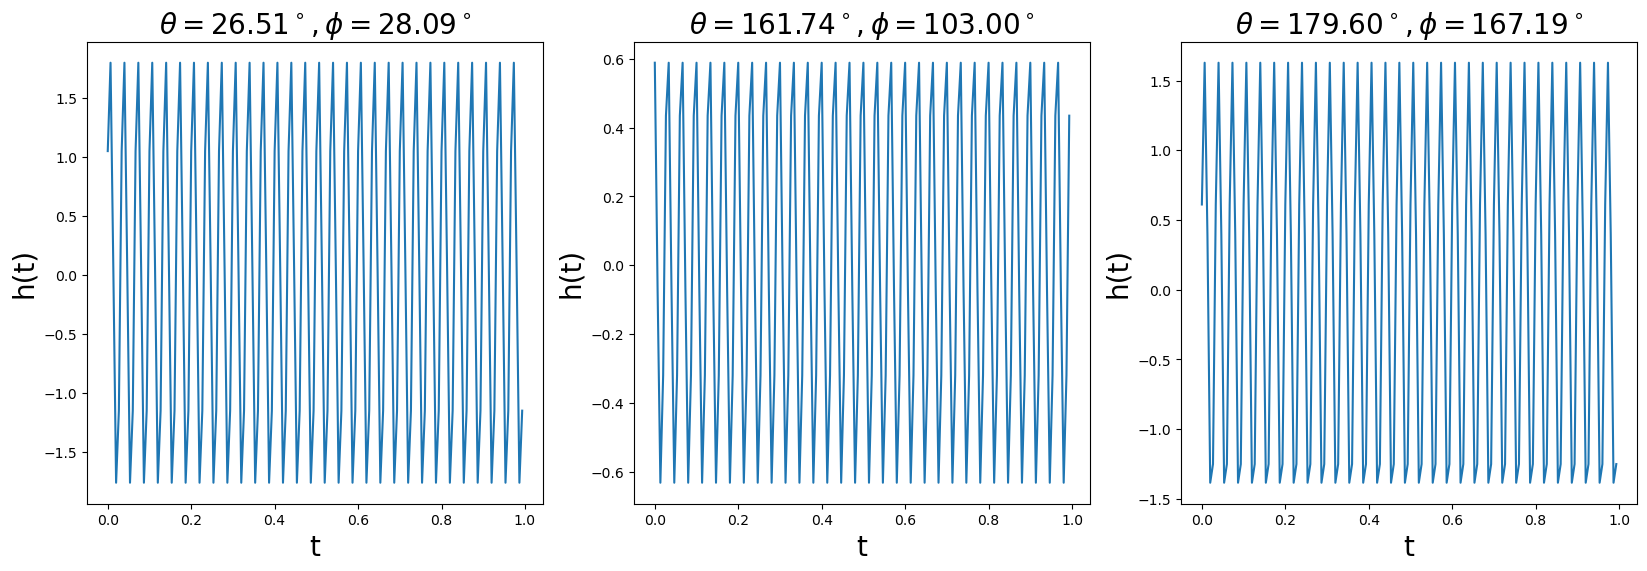

In [7]:
A = 1
B = 2
f0 = 30
phi0 = np.pi/4

fs = 5*f0
t = np.arange(0, 1, 1/fs)
hplus = A*np.sin(2*np.pi*f0*t)
hcross = B*np.sin(2*np.pi*f0*t+phi0)


def detector_response(hplus, hcross, theta, phi):
    Fplus = 0.5*(1+np.cos(theta)**2)*np.cos(2*phi)
    Fcross = np.cos(theta)*np.sin(2*phi)
    return Fplus*hplus+Fcross*hcross


Nwave = 3
theta = np.random.uniform(0, np.pi, Nwave)
phi = np.random.uniform(0, 2*np.pi, Nwave)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for theta_i, phi_i, ax_i in zip(theta, phi, ax):
    ht = detector_response(hplus, hcross, theta_i, phi_i)
    # hf = np.fft.rfft(ht)
    # f = np.fft.rfftfreq(len(ht), 1/fs)
    ax_i.plot(t, ht)
    ax_i.set_xlabel('t',fontsize=20)
    ax_i.set_ylabel('h(t)',fontsize=20)
    ax_i.set_title(r'$\theta={:.2f}^\circ, \phi={:.2f}^\circ$'.format(
        theta_i*180/np.pi, phi_i*180/np.pi),fontsize=20)
